# Computational Experiments - One Factor at a Time (OFT)

In [1]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack

In [26]:
# Constants
WOLF_MODEL = "../common/Jana_WolfGlycolysis.antimony"
TIME = "time"

This lecture discusses how to use tellurium simulations to answer science questions.
1. Workflow
   - Articulate the questions to address
   - Select the model
   - Identify parameters and species to manipulate and how they will be modified
     - Changes in initial values
     - Changes in values during simulation
   - Select measures to report
   - Visualize the results
   - Construct codes that encapsulate each step
   - Model debugging
1. Learning objectives
   - Creating functions for reuse
   - Functions in a python module
   - Test codes for reusable functions

## Wolf Model

What is the final plot?
- x axis: percent change
- y axis: parameter name
- values: color code amount changed

How organize the qualitive values?

In [3]:
WOLF_RR = te.loada(WOLF_MODEL)
START = 0
END = 5
NUMPT = 300  # number of points to simulate
WOLF_DATA = WOLF_RR.simulate(START, END, NUMPT)
print(WOLF_RR.getAntimony())

// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehy

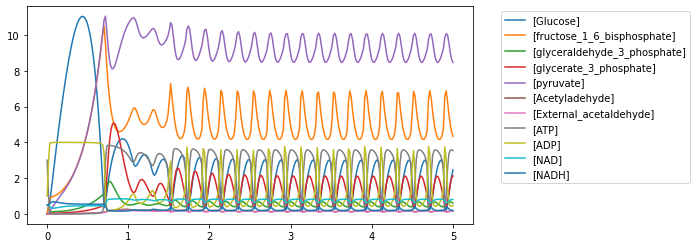

In [4]:
def timePlots(data=WOLF_DATA, title=""):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    p = ax.plot(data[:,0], data[:,1:])
    _ = ax.legend(p, data.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
timePlots()

**Question**: What is the effect of percent changes in each parameter on the amplitude and freuency of glycolytic oscillations?

## Running Simulations for a Range of Change in Parameter Values

In [42]:
parameter = "J1_k1"
changeFracs = [-1, 0, 1]
roadrunner = WOLF_RR

def runSimulations(parameter, changeFracs, isPlot=True):
    """
    Runs experiments and produces plots for the fractional changes in parameter values.

    Parameters
    ----------
    parameter: str
    changeFracs: list-float
        list of fractional change in values
          (smallest value is -1)
          
    Returns
    -------
    dict: key=change fraction, value=data
    """
    roadrunner = te.loada(WOLF_MODEL)
    baseValue = roadrunner[parameter]
    if not parameter in roadrunner.keys():
        raise ValueError("Unknown parameter name: %s" % parameter)
    resultDct = {}
    for frac in changeFracs:
        roadrunner.resetAll()
        frac = max(frac, -1)
        newValue = baseValue*(1 + frac)
        roadrunner[parameter] = newValue
        data = roadrunner.simulate(START, END, NUMPT)
        pct = int(frac*100)
        title = "%s: %f(%d)" % (parameter, newValue, pct)
        resultDct[frac] = data
        if isPlot:
            timePlots(data=data, title=title)
    return resultDct

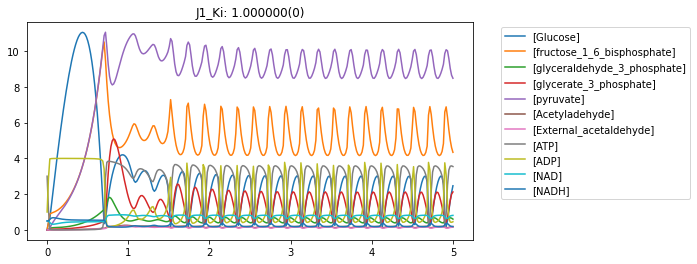

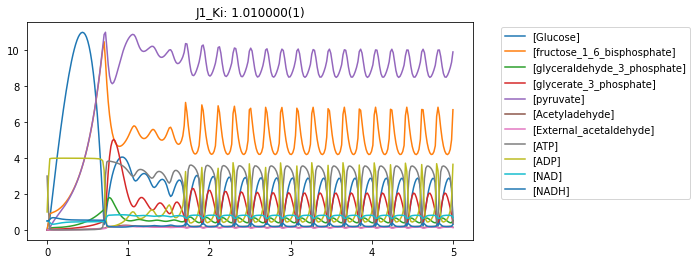

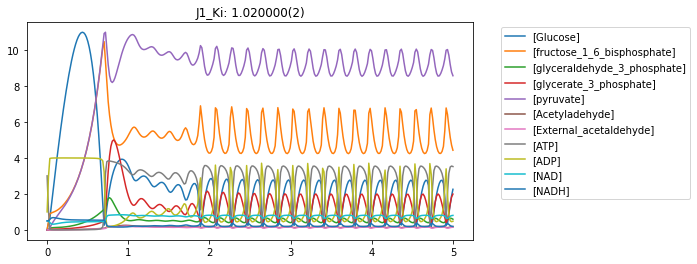

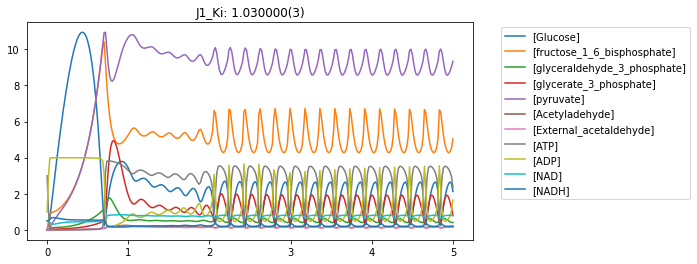

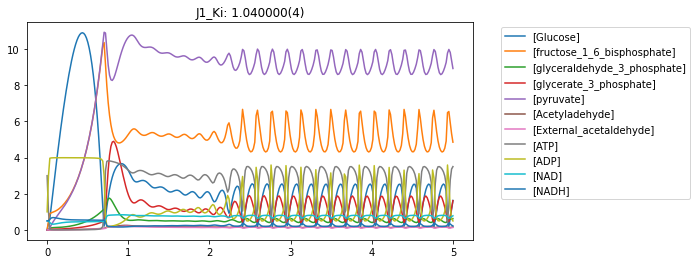

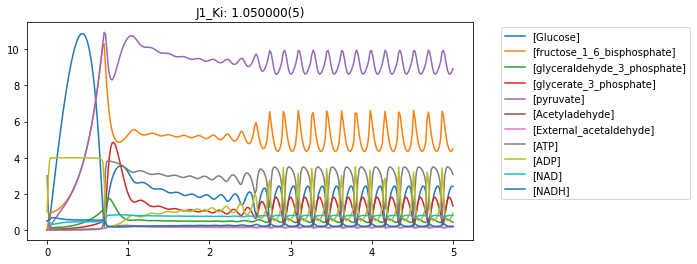

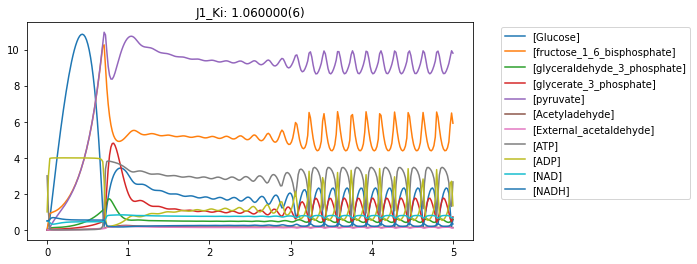

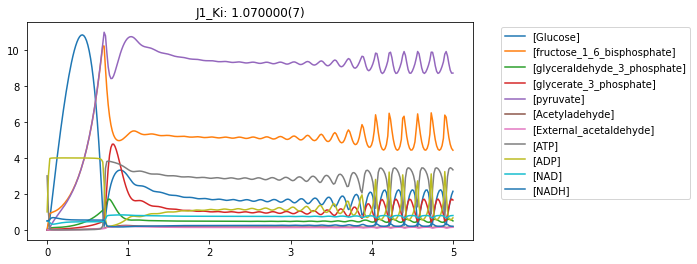

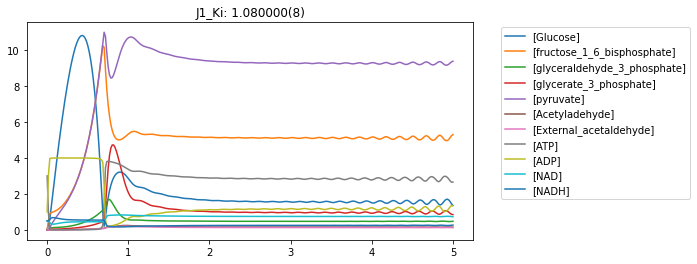

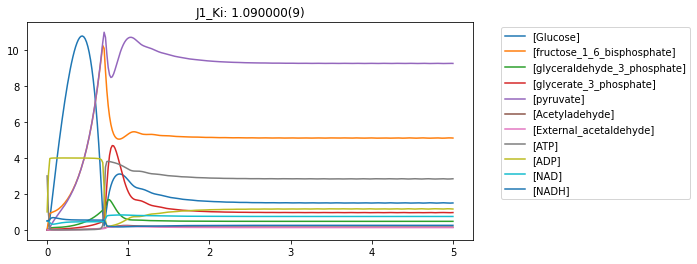

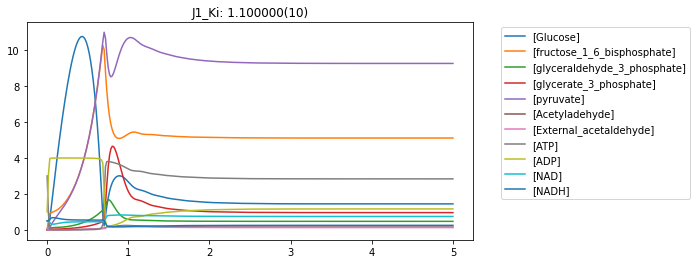

In [43]:
# Experiments 
changes = np.array(range(11))
length = len(changes)
#changes = changes - float((length - 1)/2)
changes = 0.01*changes
_ = runSimulations("J1_Ki", changes)

In [7]:
changes = np.array(range(21))
length = len(changes)
changes = changes - float((length - 1)/2)

observations
1. J1_Ki: Frequency increases to a straight line. In dynamical systems, this is a bifurcation from a "center" to a stable node.
1. Even for 1 parameter, this is painful to evaluate. Then, we need to transcribe the frequency numbers. Need to report summary of key result, not do a full plot. Also, want to have finer granularity about when the perodicities are extinguished.

## Extracting Frequency Information

The response values for our experiments will be FFT frequencies and amplitudes.
This section develops codes that calculate responses.

Our steps are:
1. Construct FFT for data. Function:
   - input: molecule, data, data ofset
   - output: list-freqs, list-fftAmplitudes
2. Plot FFTs. Should plot so make sure that the data make sense.
3. Calculate response for an experiment by molecule

In [36]:
def calculateFft(molecule, data, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data: namedArray
    offset: int
        Initial data that are not included in the FFT calculation
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

In [37]:
def plotFft(molecule, data=WOLF_DATA, ax=None, **kwargs):
    """
    Plot the FFT for a molecule.
    
    Parameters
    ----------
    data: namedArray
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, data=data, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])

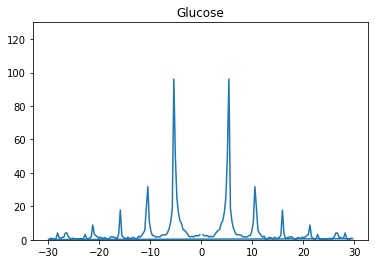

In [38]:
changes = np.array(range(41))
length = len(changes)
#changes = changes - float((length - 1)/2)
changes = 0.01*changes
dataDct = runSimulations("J1_Ki", changes, isPlot=False)
plotFft("Glucose", data=dataDct[0.02])

In [59]:
def getFrequencyAmplitude(molecule, data):
    # Return True if the expected frequency is among the topN frequencies with the largest amplitudes
    freqs, amplitudes = calculateFft(molecule, data=data)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(freqs)), key=lambda i: amplitudes[i], reverse=True)
    topIdx = sortedIndices[0]
    return freqs[topIdx], amplitudes[topIdx]

frequency, amplitude = getFrequencyAmplitude("Glucose", WOLF_DATA)
assert(frequency > 5.0)
assert(amplitude > 90)

## Running Experiments

In [40]:
getFrequencyAmplitude("Glucose", dataDct[0.02])

(5.3999999999999995, 96.10059721463962)

In [49]:
def runSimulation(parameterDct, roadrunner=None):
    """
    Runs experiments and produces plots for the fractional changes in parameter values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float (fractional change)
       
    Returns
    -------
    namedArray: results of simulation
    """
    if roadrunner is None:
        roadrunner = te.loada(WOLF_MODEL)
    else:
        roadrunner.resetAll()
    for parameter, frac in parameterDct.items():
        baseValue = roadrunner[parameter]
        roadrunner[parameter] = baseValue*(1 + frac)
    # Run the simulation
    data = roadrunner.simulate(START, END, NUMPT)
    return data

assert(len(runSimulation({"J1_Ki": 0.2})) > 0)

In [56]:
def runExperiment(parameterDct):
    """
    Runs an experiment by chaning parameters by the specified fractions.
    
    Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: fraction change the parameter
       
    Returns
    -------
    frequencyDct: dict
        key: molecule
        value: frequency with largest amplitude
    amplitudeDct: dict
        key: molecule
        value: largest amplitude
    """
    data = runSimulation(parameterDct)
    frequencyDct = {}
    amplitudeDct = {}
    molecules = [s[1:-1] for s in data.colnames if s != TIME]
    for molecule in molecules:
        frequency, amplitude = getFrequencyAmplitude(molecule, data)
        frequencyDct[molecule] = frequency
        amplitudeDct[molecule] = amplitude
    return frequencyDct, amplitudeDct

frequencyDct, amplitudeDct = runExperiment({"J1_Ki": 0.03})
assert(len(frequencyDct) == len(amplitudeDct))

In [ ]:
df runExperimentLevels(parameter, levels):
    """
    Runs experiments for a parameter at different levels.
    """